In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import hdbscan
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

### DATA PREPARATION

In [25]:
# Read in the data
# Main change from v2 to v3 is that the specific regions have been replaced with general regions
cmd_data = pd.read_csv('/data2/home/prasannaiyer/Projects/SKU_Cluster_Local/SKU_Clusters/Data/cmd_attributes_v3_upload.csv',\
    encoding = 'latin-1', decimal = '.', thousands = ',')

In [26]:
attr_input = ['Attr1_Str_qu', 'Attr2_OpPr_qu','Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']

In [27]:
attr_input_cost_model = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']
attr_input_subset = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']
attr_input_subset_cost = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']

In [28]:
# create an autoencoder class. For init function, input would be the input data, output data, layers. Also in the init function, create the autoencoder model
# For the fit function, input would be the number of epochs, batch size, and the learning rate

class auto_encoder:
    def __init__(self, input_data, output_data, ae_layers, alpha_ae = 0.2):
        self.input_data = input_data
        self.output_data = output_data
        self.ae_layers = ae_layers
        self.alpha_ae = alpha_ae
        self.autoencoder = self.create_autoencoder()
                
    def create_autoencoder(self):
        # create the input layer
        encoder_input = Input(shape=(self.input_data.shape[1],))
        nn_layer = encoder_input
        # create the encoder layers
        for i in range(len(self.ae_layers)):
            layer_name = 'encoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        encoder_output = nn_layer
        self.encoder_model = Model(encoder_input, encoder_output)
        # create the decoder layers
        for i in range(len(self.ae_layers)-2, -1, -1):
            layer_name = 'decoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        decoder_output = nn_layer
        # create the output layer
        autoencoder_output = Dense(self.output_data.shape[1], activation = 'linear')(nn_layer)
        self.ae_model = Model(encoder_input, autoencoder_output)
        # compile the model
        self.ae_model.compile(optimizer='adam', loss='mse')

    # Create a function to fit the model
    def autoencoder_fit(self, epochs = 500, batch_size = 32, verbose = 1):
        self.ae_model_hist = self.ae_model.fit(self.input_data, self.output_data, epochs = epochs, batch_size = batch_size, verbose = verbose)

    # Create a function to plot the training loss
    def plot_training_loss(self):
        plt.figure(figsize = (10, 6))
        ax = sns.lineplot(x = range(1, len(self.ae_model_hist.history['loss']) + 1), y = self.ae_model_hist.history['loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Training Loss')
        ax.set_title('Training Loss vs Epochs')
        ax.grid(linestyle='-', linewidth='0.5', color='red')

    # create a function to print the loss for epochs at specified intervals
    def print_loss(self, interval = 500):
        for i in range(0, len(self.ae_model_hist.history['loss']), interval):
            print(f'Loss at epoch {i}: {self.ae_model_hist.history["loss"][i]:.4f}')
        # print the loss at the last epoch using f-string
        print(f'Loss at epoch {len(self.ae_model_hist.history["loss"])}: {self.ae_model_hist.history["loss"][-1]:.4f}')
        
        # print minimum loss and the epoch at which it occurs
        # print(f'Minimum loss: {min(self.ae_model_hist.history['loss']):.4f} at epoch {self.ae_model_hist.history['loss'].index(min(self.ae_model_hist.history['loss']))}')
        print(f'Minimum loss: {min(self.ae_model_hist.history["loss"]):.4f} at epoch {np.argmin(self.ae_model_hist.history["loss"])}')
    
    


In [29]:
input_size = len(attr_input)
ae_layers = [input_size*2, 32, 16, 8]
ae_model = auto_encoder(cmd_data[attr_input], cmd_data[attr_input], ae_layers)

In [30]:
ae_model.ae_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 28)                420       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 28)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                928       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16)                0   

In [31]:
# fit the model
# ae_model_hist = ae_model.ae_model.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)
ae_model.autoencoder_fit(epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
21/21 [==============================] - 0s 1ms/step - loss: 0.4723
Epoch 2/500
21/21 [==============================] - 0s 1ms/step - loss: 0.3011
Epoch 3/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1916
Epoch 4/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1089
Epoch 5/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0849
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 7/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0638
Epoch 8/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 9/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0511
Epoch 10/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 11/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 12/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 13/500
21/21 [=================

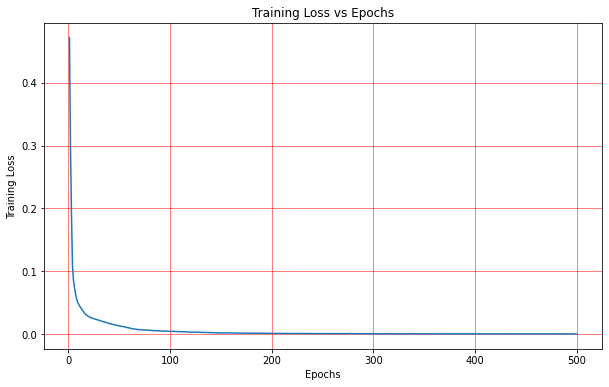

In [32]:
ae_model.plot_training_loss()

In [33]:
ae_model.print_loss()

Loss at epoch 0: 0.4723
Loss at epoch 500: 0.0002
Minimum loss: 0.0002 at epoch 495


In [11]:
input_size = cmd_data[attr_input].shape[1]
l1_size = input_size*2
l2_size = 32
l3_size = 16
bottleneck_size = 8
encoder_input = Input(shape = (input_size, ))
# encoder layer 1
encoder_m5_l1 = Dense(l1_size)(encoder_input)
encoder_m5_l1 = LeakyReLU()(encoder_m5_l1)
# encoder layer 2
encoder_m5_l2 = Dense(l2_size)(encoder_m5_l1)
encoder_m5_l2 = LeakyReLU()(encoder_m5_l2)
# encoder layer 3
encoder_m5_l3 = Dense(l3_size)(encoder_m5_l2)
encoder_m5_l3 = LeakyReLU()(encoder_m5_l3)
# encoder bottleneck layer
encoder_m5_output = Dense(bottleneck_size)(encoder_m5_l3)
encoder_m5_output = LeakyReLU()(encoder_m5_output)
# decoder layer 1
decoder_m5_l1 = Dense(l3_size)(encoder_m5_output)
decoder_m5_l1 = LeakyReLU()(decoder_m5_l1)
# decoder layer 2
decoder_m5_l2 = Dense(l2_size)(decoder_m5_l1)
decoder_m5_l2 = LeakyReLU()(decoder_m5_l2)
# decoder layer 3
decoder_m5_l3 = Dense(l1_size)(decoder_m5_l2)
decoder_m5_l3 = LeakyReLU()(decoder_m5_l3)
# decoder output layer
decoder_m5_output = Dense(input_size, activation = 'linear')(decoder_m5_l3)
# define the autoencoder model
ae_fixed_m5 = Model(encoder_input, decoder_m5_output)

In [12]:
ae_fixed_m5.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                420       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                928       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16)                0   

In [13]:
# compile the model
ae_fixed_m5.compile(optimizer='adam', loss='mse')
# fit the model
ae_fixed_m5_hist = ae_fixed_m5.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
21/21 [==============================] - 0s 1ms/step - loss: 0.4761
Epoch 2/500
21/21 [==============================] - 0s 1ms/step - loss: 0.2766
Epoch 3/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1552
Epoch 4/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1067
Epoch 5/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0870
Epoch 6/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0776
Epoch 7/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0703
Epoch 8/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 9/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0532
Epoch 10/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 11/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 12/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 13/500
21/21 [=================

In [14]:
# print the loss at epochs 100, 500, 999 and min loss. Format loss to 4 decimal places using f strings
print(f'Loss at epoch 100: {ae_fixed_m5_hist.history["loss"][99]:.4f}')
print(f'Loss at epoch 500: {ae_fixed_m5_hist.history["loss"][499]:.4f}')
#print(f'Loss at epoch 999: {ae_fixed_m5_hist.history["loss"][998]:.4f}')
print(f'Min loss: {min(ae_fixed_m5_hist.history["loss"]):.4f}')


Loss at epoch 100: 0.0022
Loss at epoch 500: 0.0002
Min loss: 0.0002


In [15]:
# print the loss at epochs 100, 500 and min loss for ae_model
print(f'Loss at epoch 100: {ae_model_hist.history["loss"][99]:.4f}')
print(f'Loss at epoch 500: {ae_model_hist.history["loss"][499]:.4f}')
print(f'Min loss: {min(ae_model_hist.history["loss"]):.4f}')

Loss at epoch 100: 0.0057
Loss at epoch 500: 0.0003
Min loss: 0.0003


In [22]:
ae_model_hist.history["loss"][500]

IndexError: list index out of range